In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd  
import seaborn as sns
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
import matplotlib.dates as mdates
%matplotlib inline

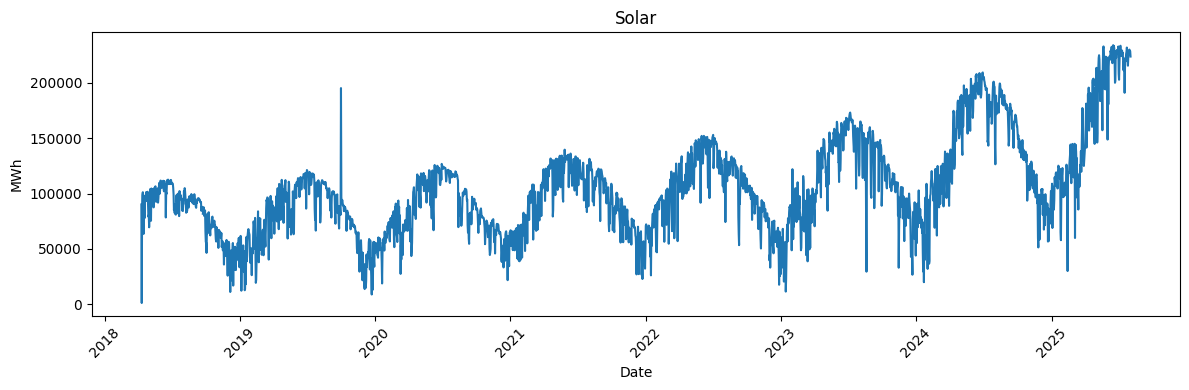

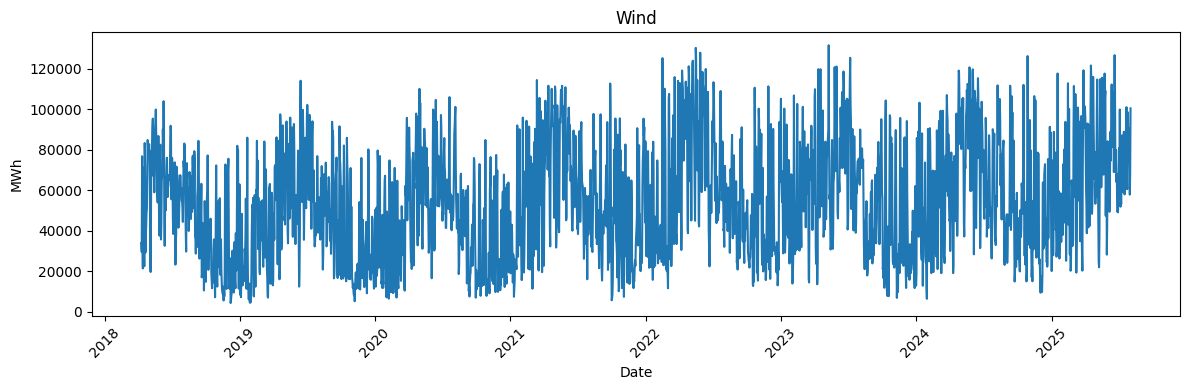

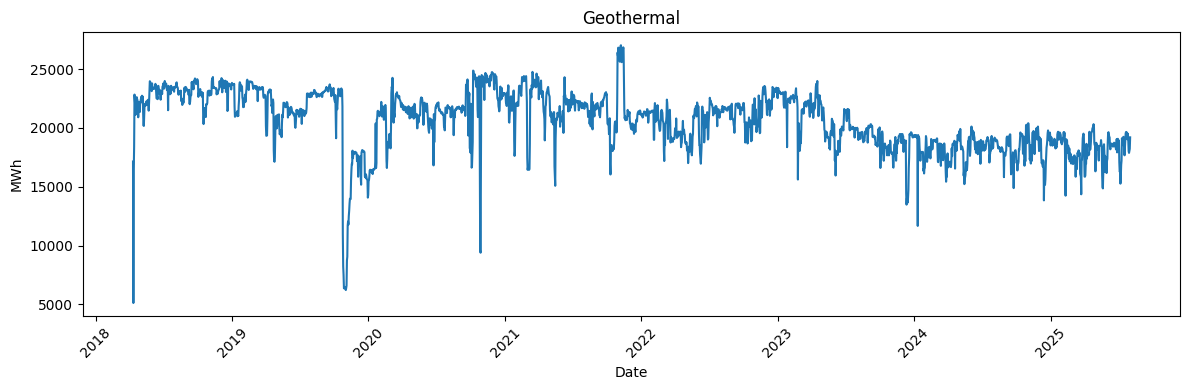

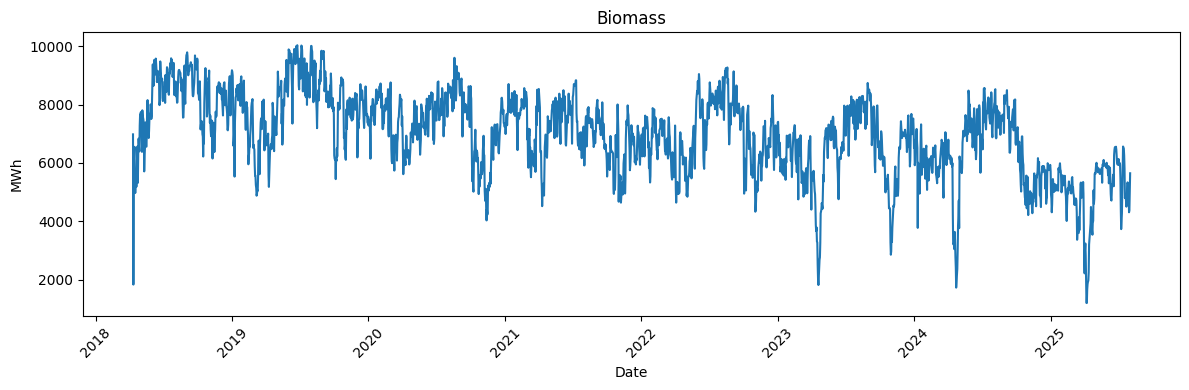

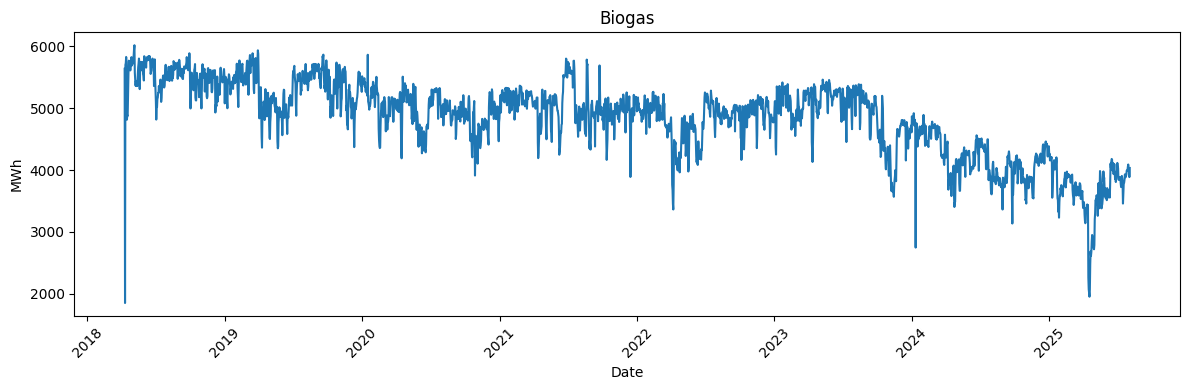

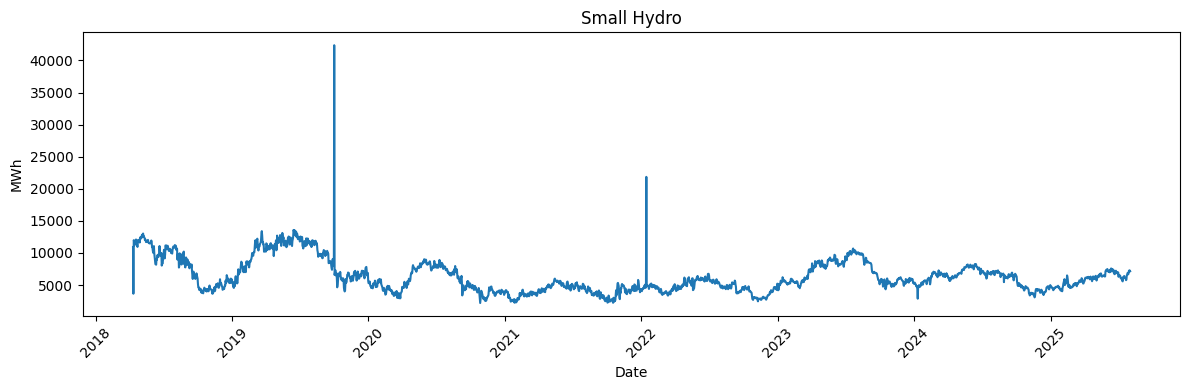

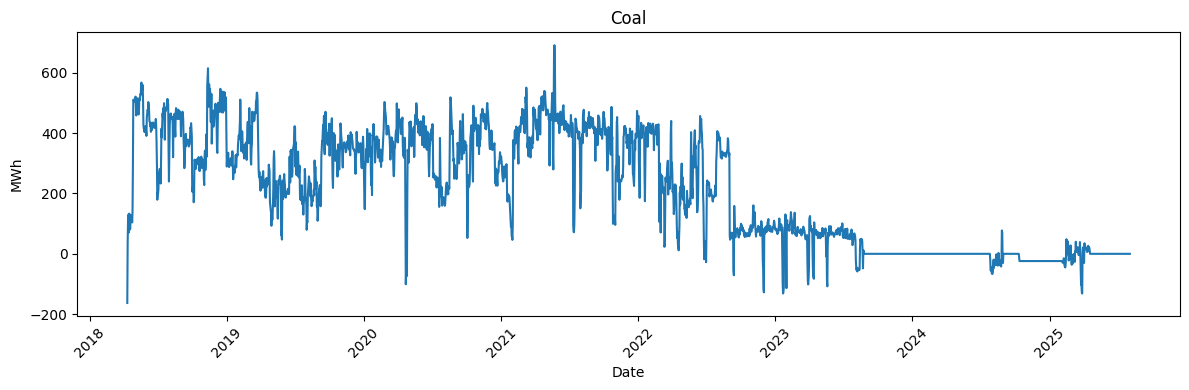

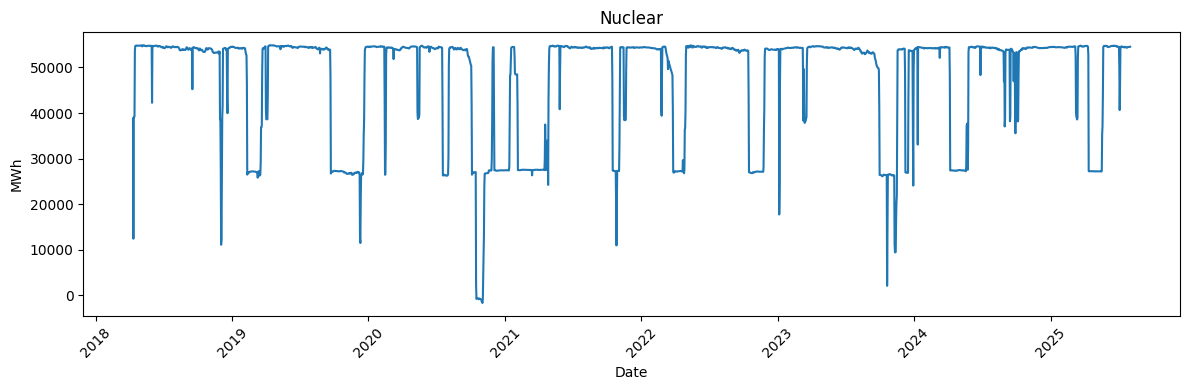

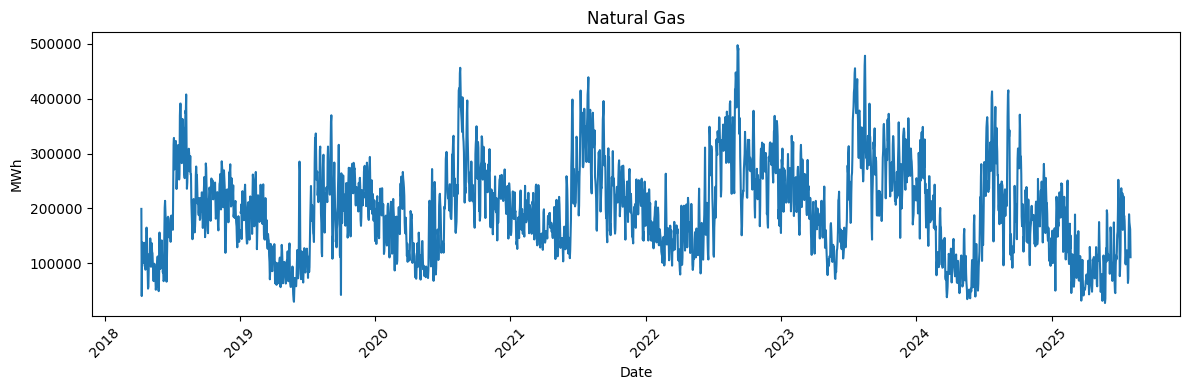

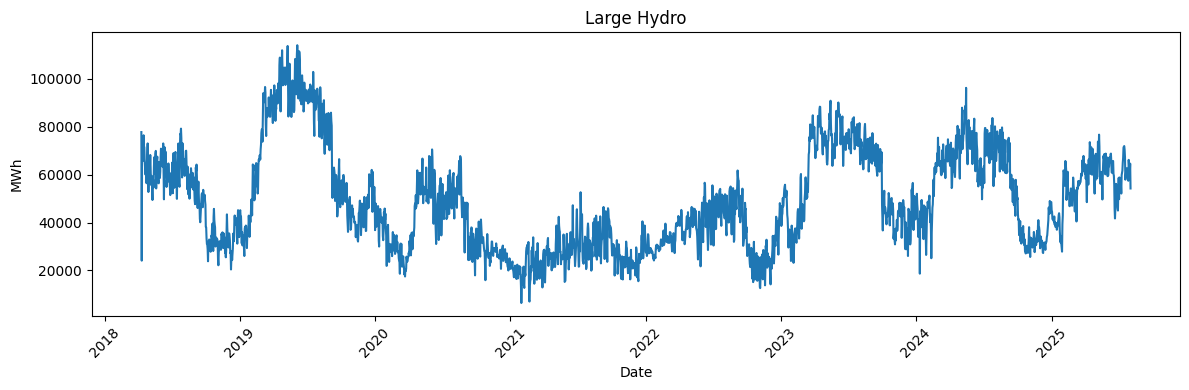

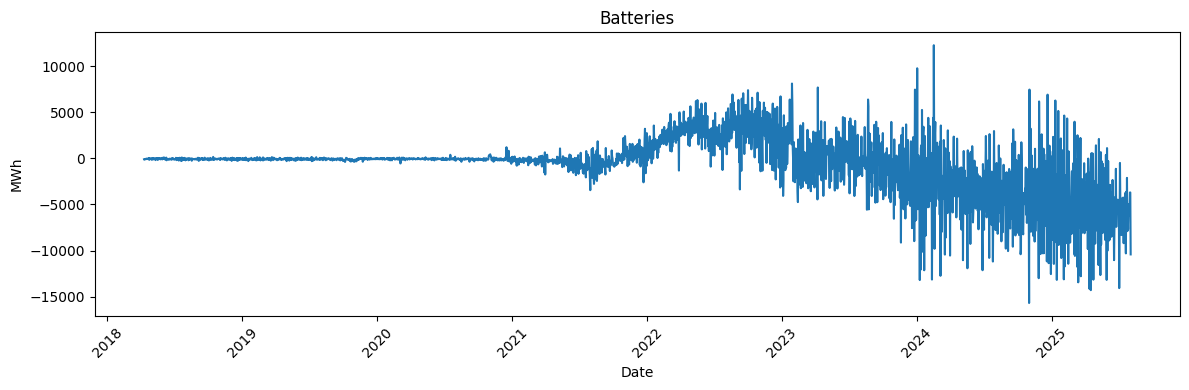

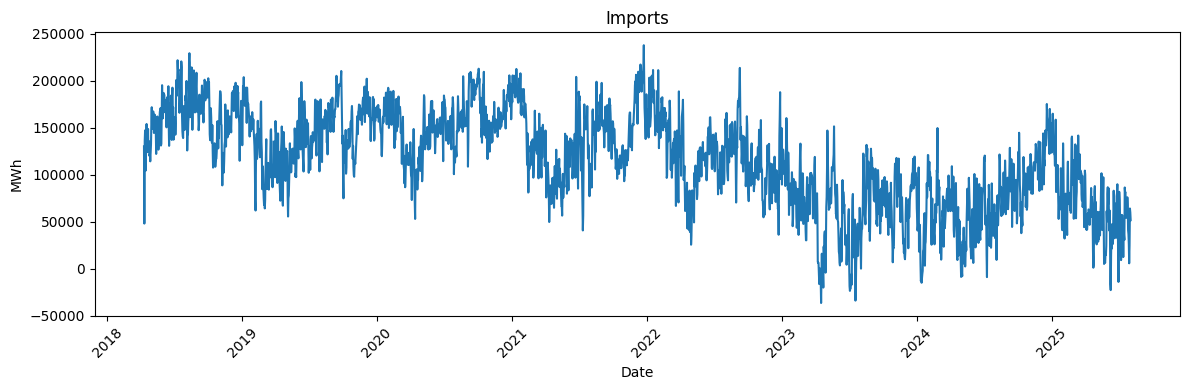

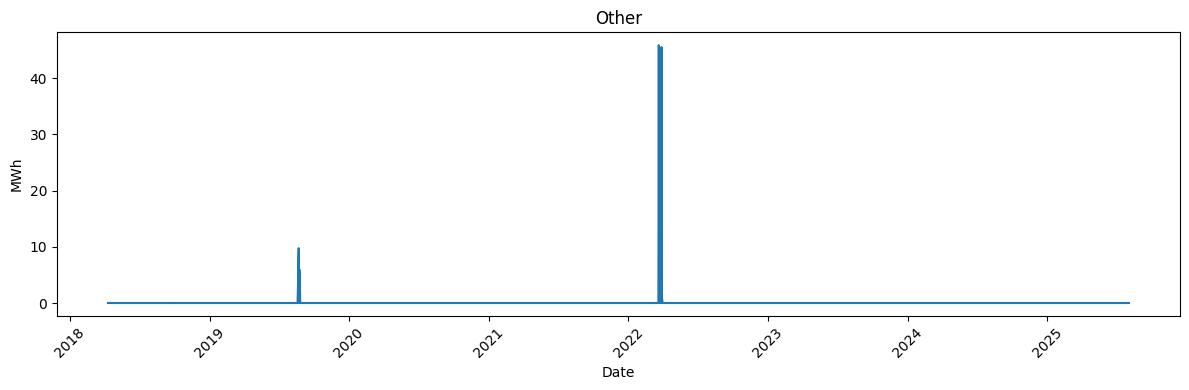

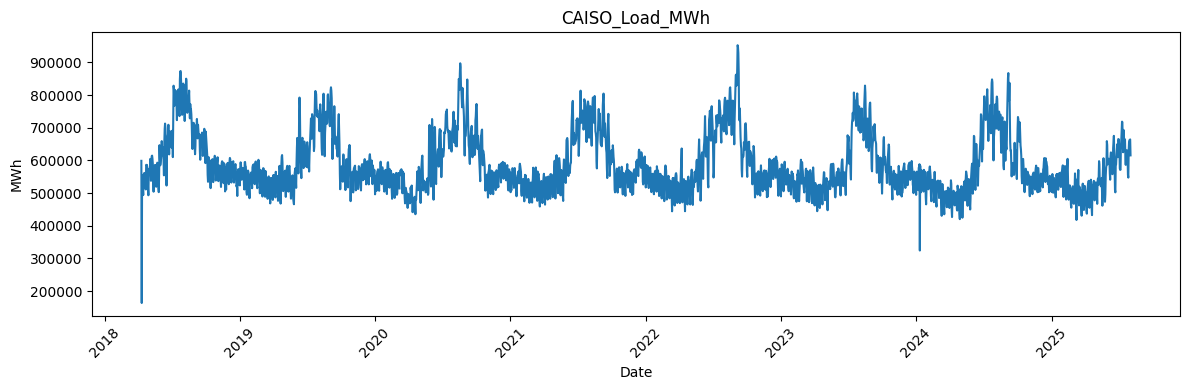

In [2]:
# Load the data
file_path = "caiso_daily_fuel_mix_and_load.csv"
df = pd.read_csv(file_path, parse_dates=["Date"]).sort_values("Date")

columns_to_plot = [
    "Solar", "Wind", "Geothermal", "Biomass", "Biogas", "Small Hydro",
    "Coal", "Nuclear", "Natural Gas", "Large Hydro", "Batteries",
    "Imports", "Other", "CAISO_Load_MWh"
]

# Configure the locator for Jan 1st of each year
years = mdates.YearLocator(base=1, month=1, day=1)  # Every Jan 1
years_fmt = mdates.DateFormatter("%Y")

# Generate one figure per series (no subplots in a single figure, per guidelines)
for col in columns_to_plot:
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df["Date"], df[col])
    
    # Format x-axis
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    plt.xticks(rotation=45)
    
    ax.set_xlabel("Date")
    ax.set_ylabel("MWh")
    ax.set_title(col)
    
    plt.tight_layout()
    plt.show()

In [3]:
# Extract time series data for each fuel source
solar_data = df[['Date', 'Solar']]
wind_data = df[['Date', 'Wind']]
geothermal_data = df[['Date', 'Geothermal']]
biomass_data = df[['Date', 'Biomass']]
biogas_data = df[['Date', 'Biogas']]
small_hydro_data = df[['Date', 'Small Hydro']]
coal_data = df[['Date', 'Coal']]
nuclear_data = df[['Date', 'Nuclear']]
natural_gas_data = df[['Date', 'Natural Gas']]
large_hydro_data = df[['Date', 'Large Hydro']]
batteries_data = df[['Date', 'Batteries']]
imports_data = df[['Date', 'Imports']]
other_data = df[['Date', 'Other']]
load_data = df[['Date', 'CAISO_Load_MWh']]

# Display the first few rows of each time series to verify
for name, data in [
    ('Solar', solar_data), ('Wind', wind_data), ('Geothermal', geothermal_data),
    ('Biomass', biomass_data), ('Biogas', biogas_data), ('Small Hydro', small_hydro_data),
    ('Coal', coal_data), ('Nuclear', nuclear_data), ('Natural Gas', natural_gas_data),
    ('Large Hydro', large_hydro_data), ('Batteries', batteries_data), 
    ('Imports', imports_data), ('Other', other_data), ('Load', load_data)
]:
    print(f"\n{name} Time Series:")
    print(data.head())


Solar Time Series:
                        Date          Solar
0  2018-04-10 00:00:00-07:00   90186.083333
1  2018-04-11 00:00:00-07:00    1167.000000
2  2018-04-12 00:00:00-07:00   86109.416667
3  2018-04-13 00:00:00-07:00   98697.416667
4  2018-04-14 00:00:00-07:00  101233.000000

Wind Time Series:
                        Date          Wind
0  2018-04-10 00:00:00-07:00  33873.500000
1  2018-04-11 00:00:00-07:00  29508.666667
2  2018-04-12 00:00:00-07:00  76746.500000
3  2018-04-13 00:00:00-07:00  33245.166667
4  2018-04-14 00:00:00-07:00  21368.500000

Geothermal Time Series:
                        Date    Geothermal
0  2018-04-10 00:00:00-07:00  17134.916667
1  2018-04-11 00:00:00-07:00   5112.666667
2  2018-04-12 00:00:00-07:00  16469.916667
3  2018-04-13 00:00:00-07:00  18386.750000
4  2018-04-14 00:00:00-07:00  22829.083333

Biomass Time Series:
                        Date      Biomass
0  2018-04-10 00:00:00-07:00  6977.000000
1  2018-04-11 00:00:00-07:00  1828.583333
2  2018-

In [4]:
# List of all time series DataFrames and their value columns
series_info = [
    (solar_data, "Solar"),
    (wind_data, "Wind"),
    (geothermal_data, "Geothermal"),
    (biomass_data, "Biomass"),
    (biogas_data, "Biogas"),
    (small_hydro_data, "Small Hydro"),
    (coal_data, "Coal"),
    (nuclear_data, "Nuclear"),
    (natural_gas_data, "Natural Gas"),
    (large_hydro_data, "Large Hydro"),
    (batteries_data, "Batteries"),
    (imports_data, "Imports"),
    (other_data, "Other"),
    (load_data, "CAISO_Load_MWh"),
]

# Calculate and print percent of NaN values for each series
for series, col in series_info:
    percent_nan = series[col].isna().mean() * 100
    print(f"{col}: {percent_nan:.2f}% NaN values")

Solar: 0.04% NaN values
Wind: 0.00% NaN values
Geothermal: 0.04% NaN values
Biomass: 0.00% NaN values
Biogas: 0.00% NaN values
Small Hydro: 0.00% NaN values
Coal: 0.00% NaN values
Nuclear: 0.00% NaN values
Natural Gas: 0.04% NaN values
Large Hydro: 0.00% NaN values
Batteries: 0.00% NaN values
Imports: 0.04% NaN values
Other: 0.04% NaN values
CAISO_Load_MWh: 0.04% NaN values


In [5]:
# Calculate the Mean Absolute Percentage Error (MAPE) for training and testing data
def calculate_mape(y_true, y_pred):
    return (100 * abs((y_true - y_pred) / y_true)).mean()

In [6]:
sources = ["Solar", "Wind", "Geothermal", "Biomass", "Biogas", "Small Hydro", "Coal", "Nuclear", "Natural Gas", "Large Hydro", "Batteries", "Imports", "Other", "CAISO_Load_MWh"]

# Drop rows with NaN values in the specified sources
df_no_nas = df.dropna(subset=sources)

# Split data in 80% train and 20% test (do not modify the seed or the split percentage)
np.random.seed(15066)
df_no_nas_train, df_no_nas_test = train_test_split(df_no_nas, train_size=0.8)

# Build X and y for test and train
features_solar = ["Solar"]
X_train_solar = df_no_nas_train[features_solar]
y_train_solar = df_no_nas_train["Solar"]
X_test_solar = df_no_nas_test[features_solar]
y_test_solar = df_no_nas_test["Solar"]

# Compute the mean crim in the train set
mean_solar_train = X_train_solar["Solar"].mean()

# Compute and report the MAPE
calculate_mape(y_test_solar, mean_solar_train)

41.78285492849403

In [7]:
# Compute the median crim in the train set
median_solar_train = X_train_solar["Solar"].median()

# Compute and report the MAPE
calculate_mape(y_test_solar, median_solar_train)

40.17971083110349

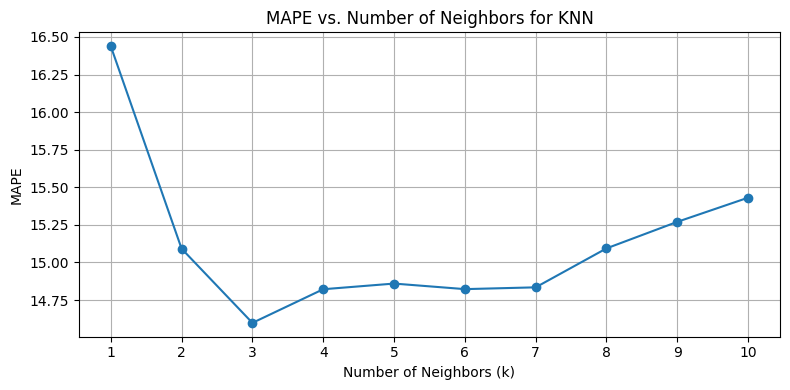

In [8]:
# Build X and y for test and train
features_23 = ["Wind", "Geothermal", "Biomass", "Biogas", "Small Hydro", "Coal", "Nuclear", "Natural Gas", "Large Hydro", "Batteries", "Imports", "Other", "CAISO_Load_MWh"]
X_train_23 = df_no_nas_train[features_23]
y_train_23 = df_no_nas_train["Solar"]
X_test_23 = df_no_nas_test[features_23]
y_test_23 = df_no_nas_test["Solar"]

# Try k from 1 to 10 and store MAPE for each
mape_scores = []
neighbors_range = range(1, 11)
for k in neighbors_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_23, y_train_23)
    preds = knn.predict(X_test_23)
    mape = calculate_mape(y_test_23, preds)
    mape_scores.append(mape)

# Plot MAPE vs. number of neighbors
plt.figure(figsize=(8, 4))
plt.plot(neighbors_range, mape_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('MAPE')
plt.title('MAPE vs. Number of Neighbors for KNN')
plt.xticks(neighbors_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Impute missing values in the 'Solar' column using KNN with 3 neighbors
imputer = KNNImputer(n_neighbors=3)
df_imputed = df.copy()
df_imputed[["Solar"]] = imputer.fit_transform(df_imputed[["Solar"]])

# Check if there are still missing values
print("Remaining NaNs in Solar after imputation:", df_imputed["Solar"].isna().sum())

Remaining NaNs in Solar after imputation: 0


In [10]:
# Build X and y for test and train
features_geo = ["Geothermal"]
X_train_geo = df_no_nas_train[features_geo]
y_train_geo = df_no_nas_train["Geothermal"]
X_test_geo = df_no_nas_test[features_geo]
y_test_geo = df_no_nas_test["Geothermal"]

# Compute the mean geo in the train set
mean_geo_train = X_train_geo["Geothermal"].mean()

# Compute and report the MAPE
calculate_mape(y_test_geo, mean_geo_train)

10.481481300875224

In [11]:
# Compute the median geo in the train set
median_geo_train = X_train_geo["Geothermal"].median()

# Compute and report the MAPE
calculate_mape(y_test_geo, median_geo_train)

10.540328973277168

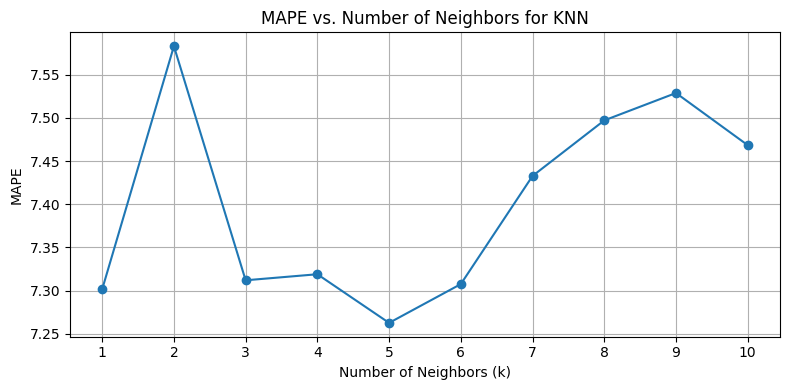

In [12]:
# Build X and y for test and train
features_23 = ["Solar", "Wind", "Biomass", "Biogas", "Small Hydro", "Coal", "Nuclear", "Natural Gas", "Large Hydro", "Batteries", "Imports", "Other", "CAISO_Load_MWh"]
X_train_23 = df_no_nas_train[features_23]
y_train_23 = df_no_nas_train["Geothermal"]
X_test_23 = df_no_nas_test[features_23]
y_test_23 = df_no_nas_test["Geothermal"]

# Try k from 1 to 10 and store MAPE for each
mape_scores = []
neighbors_range = range(1, 11)
for k in neighbors_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_23, y_train_23)
    preds = knn.predict(X_test_23)
    mape = calculate_mape(y_test_23, preds)
    mape_scores.append(mape)

# Plot MAPE vs. number of neighbors
plt.figure(figsize=(8, 4))
plt.plot(neighbors_range, mape_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('MAPE')
plt.title('MAPE vs. Number of Neighbors for KNN')
plt.xticks(neighbors_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Impute missing values in the 'Geothermal' column using KNN with 5 neighbors
imputer_geo = KNNImputer(n_neighbors=5)
df_imputed[["Geothermal"]] = imputer_geo.fit_transform(df_imputed[["Geothermal"]])

# Check if there are still missing values
print("Remaining NaNs in Geothermal after imputation:", df_imputed["Geothermal"].isna().sum())

Remaining NaNs in Geothermal after imputation: 0


In [14]:
features_natural_gas = ["Natural Gas"]

X_train_ng = df_no_nas_train[features_natural_gas]
y_train_ng = df_no_nas_train["Natural Gas"]
X_test_ng = df_no_nas_test[features_natural_gas]
y_test_ng = df_no_nas_test["Natural Gas"]

mean_ng_train = X_train_ng["Natural Gas"].mean()

calculate_mape(y_test_ng, mean_ng_train)

45.00912078252574

In [15]:
# Compute the median gn in the train set
median_ng_train = X_train_ng["Natural Gas"].median()

# Compute and report the MAPE
calculate_mape(y_test_ng, median_ng_train)

44.43109966381608

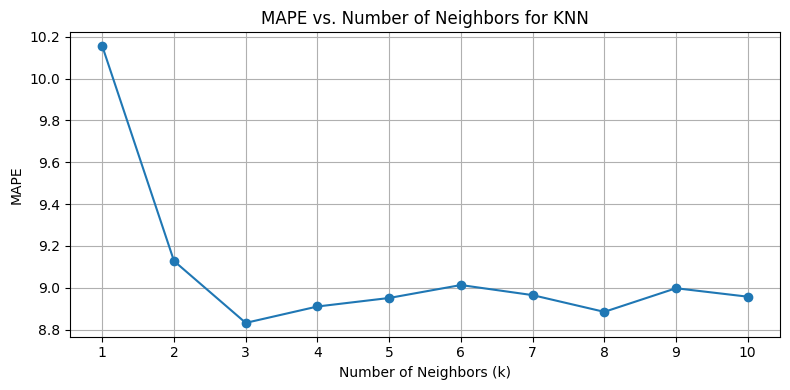

In [16]:
# Build X and y for test and train
features_23 = ["Solar", "Wind", "Geothermal", "Biomass", "Biogas", "Small Hydro", "Coal", "Nuclear", "Large Hydro", "Batteries", "Imports", "Other", "CAISO_Load_MWh"]
X_train_23 = df_no_nas_train[features_23]
y_train_23 = df_no_nas_train["Natural Gas"]
X_test_23 = df_no_nas_test[features_23]
y_test_23 = df_no_nas_test["Natural Gas"]

# Try k from 1 to 10 and store MAPE for each
mape_scores = []
neighbors_range = range(1, 11)
for k in neighbors_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_23, y_train_23)
    preds = knn.predict(X_test_23)
    mape = calculate_mape(y_test_23, preds)
    mape_scores.append(mape)

# Plot MAPE vs. number of neighbors
plt.figure(figsize=(8, 4))
plt.plot(neighbors_range, mape_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('MAPE')
plt.title('MAPE vs. Number of Neighbors for KNN')
plt.xticks(neighbors_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Impute missing values in the 'Natural Gas' column using KNN with 3 neighbors
imputer_ng = KNNImputer(n_neighbors=3)
df_imputed[["Natural Gas"]] = imputer_ng.fit_transform(df_imputed[["Natural Gas"]])

# Check if there are still missing values
print("Remaining NaNs in Natural Gas after imputation:", df_imputed["Natural Gas"].isna().sum())

Remaining NaNs in Natural Gas after imputation: 0


In [18]:
features_imports = ["Imports"]

X_train_imports = df_no_nas_train[features_imports]
y_train_imports = df_no_nas_train["Imports"]
X_test_imports = df_no_nas_test[features_imports]
y_test_imports = df_no_nas_test["Imports"]

mean_imports_train = X_train_imports["Imports"].mean()

calculate_mape(y_test_imports, mean_imports_train)

96.48376094579488

In [19]:
# Compute the median imports in the train set
median_imports_train = X_train_imports["Imports"].median()

# Compute and report the MAPE
calculate_mape(y_test_imports, median_imports_train)

99.68942105912703

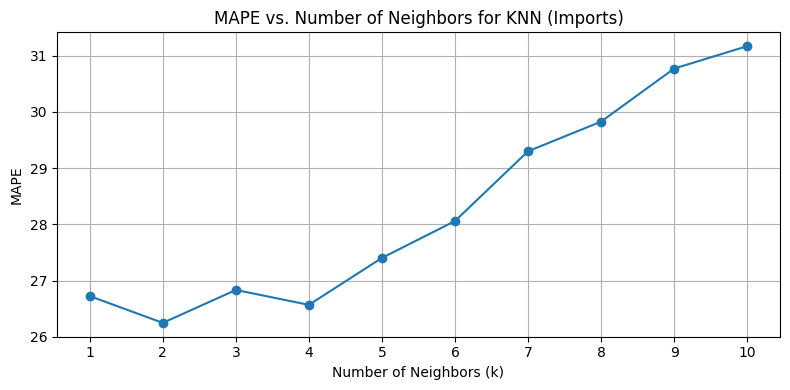

In [20]:
# Build X and y for test and train for Imports
features_23 = ["Solar", "Wind", "Geothermal", "Biomass", "Biogas", "Small Hydro", "Coal", "Nuclear", "Natural Gas", "Large Hydro", "Batteries", "Other", "CAISO_Load_MWh"]
X_train_23 = df_no_nas_train[features_23]
y_train_23 = df_no_nas_train["Imports"]
X_test_23 = df_no_nas_test[features_23]
y_test_23 = df_no_nas_test["Imports"]

# Try k from 1 to 10 and store MAPE for each
mape_scores = []
neighbors_range = range(1, 11)
for k in neighbors_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_23, y_train_23)
    preds = knn.predict(X_test_23)
    mape = calculate_mape(y_test_23, preds)
    mape_scores.append(mape)

# Plot MAPE vs. number of neighbors
plt.figure(figsize=(8, 4))
plt.plot(neighbors_range, mape_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('MAPE')
plt.title('MAPE vs. Number of Neighbors for KNN (Imports)')
plt.xticks(neighbors_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Impute missing values in the 'Imports' column using KNN with 2 neighbors
imputer_imports = KNNImputer(n_neighbors=2)
df_imputed[["Imports"]] = imputer_imports.fit_transform(df_imputed[["Imports"]])

# Check if there are still missing values
print("Remaining NaNs in Imports after imputation:", df_imputed["Imports"].isna().sum())

Remaining NaNs in Imports after imputation: 0


In [22]:
features_other = ["Other"]

X_train_other = df_no_nas_train[features_other]
y_train_other = df_no_nas_train["Other"]
X_test_other = df_no_nas_test[features_other]
y_test_other = df_no_nas_test["Other"]

median_other_train = X_train_other["Other"].median()

calculate_mape(y_test_other, median_other_train)

100.0

In [23]:
# Impute missing values in the 'Other' column using the median
median_other = df["Other"].median()
df_imputed["Other"] = df_imputed["Other"].fillna(median_other)

# Check if there are still missing values
print("Remaining NaNs in Other after imputation:", df_imputed["Other"].isna().sum())

Remaining NaNs in Other after imputation: 0


In [24]:
features_load = ["CAISO_Load_MWh"]

X_train_load = df_no_nas_train[features_load]
y_train_load = df_no_nas_train["CAISO_Load_MWh"]
X_test_load = df_no_nas_test[features_load]
y_test_load = df_no_nas_test["CAISO_Load_MWh"]

mean_load_train = X_train_load["CAISO_Load_MWh"].mean()

calculate_mape(y_test_load, mean_load_train)

11.651833092949861

In [25]:
# Compute the median load in the train set
median_load_train = X_train_load["CAISO_Load_MWh"].median()

# Compute and report the MAPE
calculate_mape(y_test_load, median_load_train)

10.986048977348341

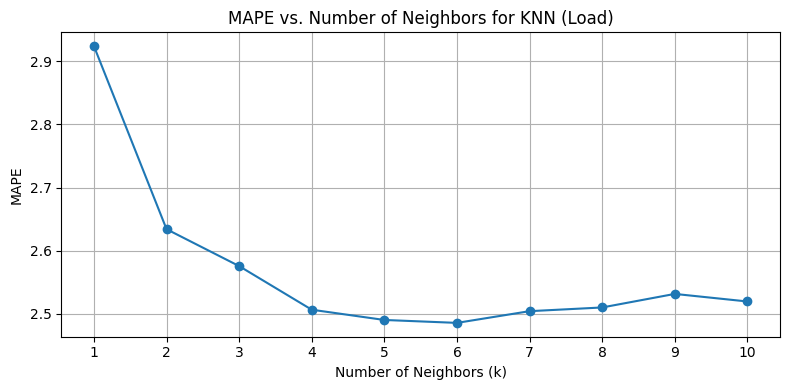

In [26]:
# Build X and y for test and train for Load
features_23 = ["Solar", "Wind", "Geothermal", "Biomass", "Biogas", "Small Hydro", "Coal", "Nuclear", "Natural Gas", "Large Hydro", "Batteries", "Imports", "Other"]
X_train_23 = df_no_nas_train[features_23]
y_train_23 = df_no_nas_train["CAISO_Load_MWh"]
X_test_23 = df_no_nas_test[features_23]
y_test_23 = df_no_nas_test["CAISO_Load_MWh"]

# Try k from 1 to 10 and store MAPE for each
mape_scores = []
neighbors_range = range(1, 11)
for k in neighbors_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_23, y_train_23)
    preds = knn.predict(X_test_23)
    mape = calculate_mape(y_test_23, preds)
    mape_scores.append(mape)

# Plot MAPE vs. number of neighbors
plt.figure(figsize=(8, 4))
plt.plot(neighbors_range, mape_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('MAPE')
plt.title('MAPE vs. Number of Neighbors for KNN (Load)')
plt.xticks(neighbors_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Impute missing values in the 'CAISO_Load_MWh' column using KNN with 6 neighbors
imputer_load = KNNImputer(n_neighbors=6)
df_imputed[["CAISO_Load_MWh"]] = imputer_load.fit_transform(df_imputed[["CAISO_Load_MWh"]])

# Check if there are still missing values
print("Remaining NaNs in CAISO_Load_MWh after imputation:", df_imputed["CAISO_Load_MWh"].isna().sum())

Remaining NaNs in CAISO_Load_MWh after imputation: 0


In [28]:
# Save the imputed dataframe to a CSV file
df_imputed.to_csv("caiso_daily_fuel_mix_and_load_imputed.csv", index=False)

In [30]:
# Extract time series data for each fuel source from the imputed dataframe
solar_data_imp = df_imputed[['Date', 'Solar']]
wind_data_imp = df_imputed[['Date', 'Wind']]
geothermal_data_imp = df_imputed[['Date', 'Geothermal']]
biomass_data_imp = df_imputed[['Date', 'Biomass']]
biogas_data_imp = df_imputed[['Date', 'Biogas']]
small_hydro_data_imp = df_imputed[['Date', 'Small Hydro']]
coal_data_imp = df_imputed[['Date', 'Coal']]
nuclear_data_imp = df_imputed[['Date', 'Nuclear']]
natural_gas_data_imp = df_imputed[['Date', 'Natural Gas']]
large_hydro_data_imp = df_imputed[['Date', 'Large Hydro']]
batteries_data_imp = df_imputed[['Date', 'Batteries']]
imports_data_imp = df_imputed[['Date', 'Imports']]
other_data_imp = df_imputed[['Date', 'Other']]
load_data_imp = df_imputed[['Date', 'CAISO_Load_MWh']]

# Display the first few rows of each imputed time series to verify
for name, data in [
    ('Solar', solar_data_imp), ('Wind', wind_data_imp), ('Geothermal', geothermal_data_imp),
    ('Biomass', biomass_data_imp), ('Biogas', biogas_data_imp), ('Small Hydro', small_hydro_data_imp),
    ('Coal', coal_data_imp), ('Nuclear', nuclear_data_imp), ('Natural Gas', natural_gas_data_imp),
    ('Large Hydro', large_hydro_data_imp), ('Batteries', batteries_data_imp), 
    ('Imports', imports_data_imp), ('Other', other_data_imp), ('Load', load_data_imp)
]:
    print(f"\n{name} (Imputed) Time Series:")
    print(data.head())

# List of all imputed time series DataFrames and their value columns
series_info_imp = [
    (solar_data_imp, "Solar"),
    (wind_data_imp, "Wind"),
    (geothermal_data_imp, "Geothermal"),
    (biomass_data_imp, "Biomass"),
    (biogas_data_imp, "Biogas"),
    (small_hydro_data_imp, "Small Hydro"),
    (coal_data_imp, "Coal"),
    (nuclear_data_imp, "Nuclear"),
    (natural_gas_data_imp, "Natural Gas"),
    (large_hydro_data_imp, "Large Hydro"),
    (batteries_data_imp, "Batteries"),
    (imports_data_imp, "Imports"),
    (other_data_imp, "Other"),
    (load_data_imp, "CAISO_Load_MWh"),
]

# Calculate and print percent of NaN values for each imputed series
for series, col in series_info_imp:
    percent_nan = series[col].isna().mean() * 100
    print(f"{col} (Imputed): {percent_nan:.2f}% NaN values")


Solar (Imputed) Time Series:
                        Date          Solar
0  2018-04-10 00:00:00-07:00   90186.083333
1  2018-04-11 00:00:00-07:00    1167.000000
2  2018-04-12 00:00:00-07:00   86109.416667
3  2018-04-13 00:00:00-07:00   98697.416667
4  2018-04-14 00:00:00-07:00  101233.000000

Wind (Imputed) Time Series:
                        Date          Wind
0  2018-04-10 00:00:00-07:00  33873.500000
1  2018-04-11 00:00:00-07:00  29508.666667
2  2018-04-12 00:00:00-07:00  76746.500000
3  2018-04-13 00:00:00-07:00  33245.166667
4  2018-04-14 00:00:00-07:00  21368.500000

Geothermal (Imputed) Time Series:
                        Date    Geothermal
0  2018-04-10 00:00:00-07:00  17134.916667
1  2018-04-11 00:00:00-07:00   5112.666667
2  2018-04-12 00:00:00-07:00  16469.916667
3  2018-04-13 00:00:00-07:00  18386.750000
4  2018-04-14 00:00:00-07:00  22829.083333

Biomass (Imputed) Time Series:
                        Date      Biomass
0  2018-04-10 00:00:00-07:00  6977.000000
1  2018-04

In [31]:
# Calculate the split point (70% of data)
split_point = int(len(df_imputed) * 0.7)

# Split each imputed time series into training and testing sets
# Solar
solar_train = solar_data_imp.iloc[:split_point]
solar_test = solar_data_imp.iloc[split_point:]

# Wind
wind_train = wind_data_imp.iloc[:split_point]
wind_test = wind_data_imp.iloc[split_point:]

# Geothermal
geothermal_train = geothermal_data_imp.iloc[:split_point]
geothermal_test = geothermal_data_imp.iloc[split_point:]

# Biomass
biomass_train = biomass_data_imp.iloc[:split_point]
biomass_test = biomass_data_imp.iloc[split_point:]

# Biogas
biogas_train = biogas_data_imp.iloc[:split_point]
biogas_test = biogas_data_imp.iloc[split_point:]

# Small Hydro
small_hydro_train = small_hydro_data_imp.iloc[:split_point]
small_hydro_test = small_hydro_data_imp.iloc[split_point:]

# Coal
coal_train = coal_data_imp.iloc[:split_point]
coal_test = coal_data_imp.iloc[split_point:]

# Nuclear
nuclear_train = nuclear_data_imp.iloc[:split_point]
nuclear_test = nuclear_data_imp.iloc[split_point:]

# Natural Gas
natural_gas_train = natural_gas_data_imp.iloc[:split_point]
natural_gas_test = natural_gas_data_imp.iloc[split_point:]

# Large Hydro
large_hydro_train = large_hydro_data_imp.iloc[:split_point]
large_hydro_test = large_hydro_data_imp.iloc[split_point:]

# Batteries
batteries_train = batteries_data_imp.iloc[:split_point]
batteries_test = batteries_data_imp.iloc[split_point:]

# Imports
imports_train = imports_data_imp.iloc[:split_point]
imports_test = imports_data_imp.iloc[split_point:]

# Other
other_train = other_data_imp.iloc[:split_point]
other_test = other_data_imp.iloc[split_point:]

# Load
load_train = load_data_imp.iloc[:split_point]
load_test = load_data_imp.iloc[split_point:]

print(f"Training set size: {len(solar_train)} samples")
print(f"Testing set size: {len(solar_test)} samples")

Training set size: 1870 samples
Testing set size: 802 samples


In [32]:
# Fit an auto_arima model to the solar training data
solar_arima_model = auto_arima(
    solar_train["Solar"],
    seasonal=True,
    m=365,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
print(solar_arima_model.summary())

/Users/shane/Documents/MIT 2025-2026/Summer/15.066 System Optimization and Analysis for Operations/15066_final_project/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shane/Documents/MIT 2025-2026/Summer/15.066 System Optimization and Analysis for Operations/15066_final_project/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shane/Documents/MIT 2025-2026/Summer/15.066 System Optimization and Analysis for Operations/15066_final_project/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shane/Documents/MIT 2025-2026/Summer/15.066 System Optimization an

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[365] intercept   : AIC=inf, Time=237.89 sec
 ARIMA(0,1,0)(0,0,0)[365] intercept   : AIC=41046.738, Time=0.12 sec


/Users/shane/Documents/MIT 2025-2026/Summer/15.066 System Optimization and Analysis for Operations/15066_final_project/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shane/Documents/MIT 2025-2026/Summer/15.066 System Optimization and Analysis for Operations/15066_final_project/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 